In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from qe_inequality_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# QE experiment

In [4]:
NRUNS = 8
burn_in_period = 0

In [5]:
params = {"fundamental_values": [105, 166], "asset_types": ['bond', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 500, "std_fundamentals": [0.1, 0.1],
              "std_noise": 0.1007, "w_random": 0.1,
              "strat_share_chartists": 0.0,
              "init_assets": [200, 200], "base_risk_aversion": 1.0,
              'spread_max': 0.004087, "horizon": 200,
              "fundamentalist_horizon_multiplier": 0.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0,
              "average_learning_ability": 0.0, 'money_multiplier': 1.0,
              "bond_mean_reversion": 0.8,
              "qe_perc_size": 0.0, "qe_start": 10, "qe_end": 50, "qe_asset_index": 0}

In [6]:
steps = 10
qe_size = [x / 100.0 for x in range(0, 100 + steps, steps)]
qe_size

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [7]:
experiments = len(qe_size)

In [8]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qe_size[exp])

In [9]:
trdrs = []
orbs = []
central_banks = []

for exp in range(experiments):
    params['qe_perc_size'] = qe_size[exp]
    for seed in range(NRUNS): 
        traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
        traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
        central_banks.append(central_bank)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

# QE effects 

## 1 On prices

In [10]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS * experiments)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS * experiments)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][idx].transaction_volumes_history] for run in range(NRUNS * experiments)]).transpose()
    asset_volumes.append(av)

## Compare extremes

In [11]:
av_p0_experiments = []
av_p1_experiments = []

av_fn0_experiments = []
av_fn1_experiments = []

av_vol0_experiments = []
av_vol1_experiments = []

for x in range(experiments):
    y = x*NRUNS
    
    #prices
    p0 = asset_prices[0][range(y,y+NRUNS)]
    av_p0_experiments.append(p0.mean(axis=1))
    
    p1 = asset_prices[-1][range(y,y+NRUNS)]
    av_p1_experiments.append(p1.mean(axis=1))
    
    # fundamentals
    f0 = asset_fundamentals[0][range(y,y+NRUNS)]
    av_fn0_experiments.append(f0.mean(axis=1))
    
    f1 = asset_fundamentals[-1][range(y,y+NRUNS)]
    av_fn1_experiments.append(f1.mean(axis=1))
    
    # volumes
    v0 = asset_volumes[0][range(y,y+NRUNS)]
    av_vol0_experiments.append(v0.mean(axis=1))
    
    v1 = asset_volumes[-1][range(y,y+NRUNS)]
    av_vol1_experiments.append(v1.mean(axis=1))

Text(0, 0.5, 'Volume')

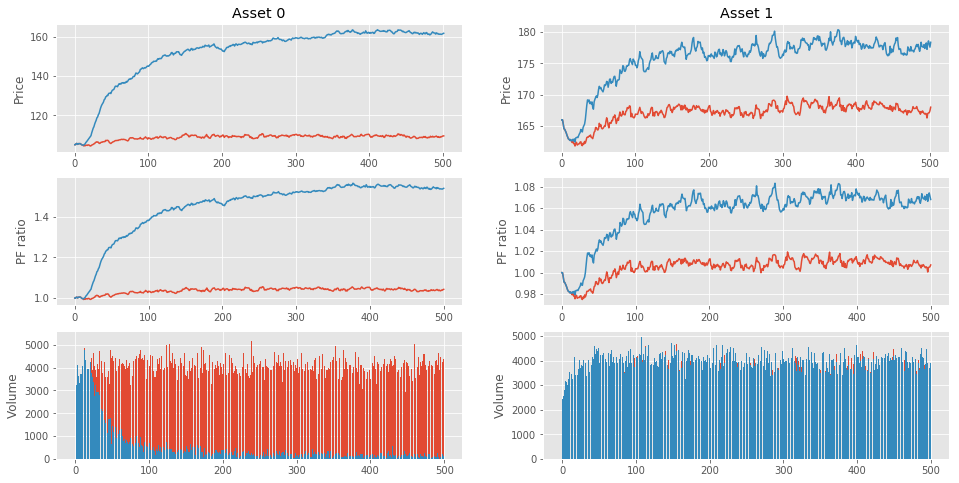

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(av_p0_experiments[0].index, av_p0_experiments[0], label='no-qe')
ax1.plot(av_p0_experiments[-1].index, av_p0_experiments[-1], label='qe')
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(av_p1_experiments[0].index, av_p1_experiments[0], label='no-qe')
ax2.plot(av_p1_experiments[-1].index, av_p1_experiments[-1], label='qe')
ax2.set_ylabel('Price')

# pf ratio's 
ax3.plot(av_p0_experiments[0].index, av_p0_experiments[0] / av_fn0_experiments[0])
ax3.plot(av_p0_experiments[-1].index, av_p0_experiments[-1] / av_fn0_experiments[1])
ax3.set_ylabel('PF ratio')

ax4.plot(av_p1_experiments[0].index, av_p1_experiments[0] / av_fn1_experiments[0])
ax4.plot(av_p1_experiments[-1].index, av_p1_experiments[-1] / av_fn1_experiments[1])
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(av_vol0_experiments[0].index, av_vol0_experiments[0])
ax5.bar(av_vol0_experiments[-1].index, av_vol0_experiments[-1])
ax5.set_ylabel('Volume')

ax6.bar(av_vol1_experiments[0].index, av_vol1_experiments[0])
ax6.bar(av_vol1_experiments[-1].index, av_vol1_experiments[-1])
ax6.set_ylabel('Volume')


### Explore average effects and conf intervals of QE size

In [32]:
# split the data in parts of 10 
p0_averages = []
p0_conf_interval_uppers = []
p0_conf_intervals_lowers = []

p1_averages = []
p1_conf_interval_uppers = []
p1_conf_intervals_lowers = []

pf0_averages = []
pf0_conf_interval_uppers = []
pf0_conf_intervals_lowers = []

pf1_averages = []
pf1_conf_interval_uppers = []
pf1_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    p0 = asset_prices[0][range(y,y+NRUNS)]
    p1 = asset_prices[-1][range(y,y+NRUNS)]
    f0 = asset_fundamentals[0][range(y,y+NRUNS)]
    f1 = asset_fundamentals[-1][range(y,y+NRUNS)]
    
    pf0 = np.mean(p0 / f0)
    pf1 = np.mean(p1 / f1)
    
    p0 = np.mean(p0)
    p1 = np.mean(p1)
    
    # p0
    p0_averages.append(np.mean(p0))
    sample_stdev = np.std(p0)
    sigma = sample_stdev/math.sqrt(len(p0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p0), scale = sigma) 
    p0_conf_interval_uppers.append(upper)
    p0_conf_intervals_lowers.append(lower)
    
    # p1
    p1_averages.append(np.mean(p1))
    sample_stdev = np.std(p1)
    sigma = sample_stdev/math.sqrt(len(p1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p1), scale = sigma) 
    p1_conf_interval_uppers.append(upper)
    p1_conf_intervals_lowers.append(lower)
    
    # pf0
    pf0_averages.append(np.mean(pf0))
    sample_stdev = np.std(pf0)
    sigma = sample_stdev/math.sqrt(len(pf0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf0), scale = sigma) 
    pf0_conf_interval_uppers.append(upper)
    pf0_conf_intervals_lowers.append(lower)
    
    # pf1
    pf1_averages.append(np.mean(pf1))
    sample_stdev = np.std(pf1)
    sigma = sample_stdev/math.sqrt(len(pf1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf1), scale = sigma) 
    pf1_conf_interval_uppers.append(upper)
    pf1_conf_intervals_lowers.append(lower)

In [21]:
data = pd.DataFrame({'av_price_a0': [np.mean(p) for p in av_p0_experiments], 
                     'av_price_a1': [np.mean(p) for p in av_p1_experiments] , 
                     'av_pf_a0': [np.mean(av_p0_experiments[idx] / av_fn0_experiments[idx]) for idx in range(experiments)], 
                     'av_pf_a1': [np.mean(av_p1_experiments[idx] / av_fn1_experiments[idx]) for idx in range(experiments)],
                     'lin_size_qe': qe_size})
data['const'] = 1

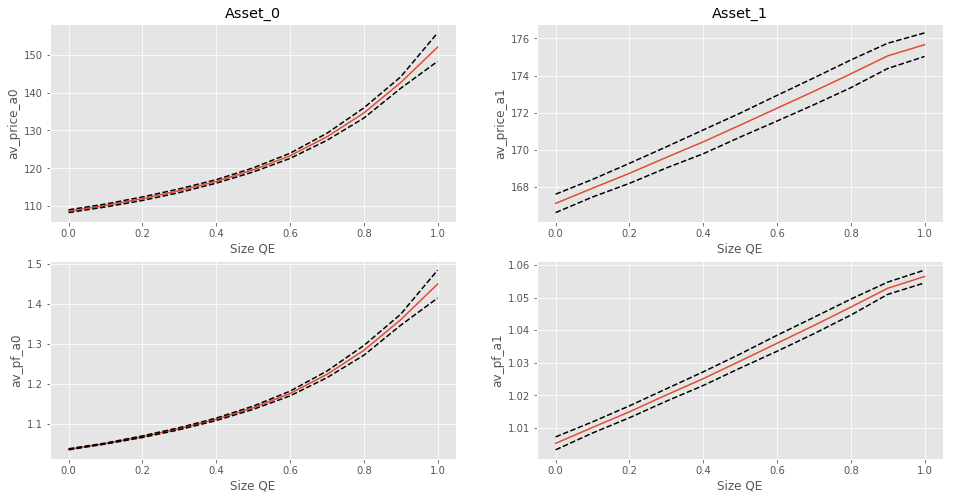

In [36]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.set_title('Asset_0')
ax2.set_title('Asset_1')

ax1.plot(data['lin_size_qe'], p0_averages)
ax1.plot(data['lin_size_qe'], p0_conf_interval_uppers, 'k--')
ax1.plot(data['lin_size_qe'], p0_conf_intervals_lowers, 'k--')
ax1.set_ylabel('av_price_a0')

ax2.plot(data['lin_size_qe'], p1_averages)
ax2.plot(data['lin_size_qe'], p1_conf_interval_uppers, 'k--')
ax2.plot(data['lin_size_qe'], p1_conf_intervals_lowers, 'k--')
ax2.set_ylabel('av_price_a1')

ax3.plot(data['lin_size_qe'], pf0_averages)
ax3.plot(data['lin_size_qe'], pf0_conf_interval_uppers, 'k--')
ax3.plot(data['lin_size_qe'], pf0_conf_intervals_lowers, 'k--')
ax3.set_ylabel('av_pf_a0')

ax4.plot(data['lin_size_qe'], pf1_averages)
ax4.plot(data['lin_size_qe'], pf1_conf_interval_uppers, 'k--')
ax4.plot(data['lin_size_qe'], pf1_conf_intervals_lowers, 'k--')
ax4.set_ylabel('av_pf_a1')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('Size QE')
    
fig.savefig('qe_size_effect_on_prices.png')

## 2 On inequality

In [46]:
ginis = []
palmas = []
twtws = []
#asset_price_inflation = []
#price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in traders])
    asset0 = np.array([x.var.assets[0][-1] for x in traders])
    asset1 = np.array([x.var.assets[1][-1] for x in traders])
    wealth = money_end + (asset0_end * orbs[idx][0].tick_close_price[-1]) + (asset1_end * orbs[idx][1].tick_close_price[-1])
    
    #asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    #price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [48]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

twtw_averages = []
twtw_conf_interval_uppers = []
twtw_conf_intervals_lowers = []

price_div_stdev_av = []
price_div_stdev_uppers = []
price_div_stdev_lowers = []

redistr_av = []
redistr_uppers = []
redistr_lowers = []

skew_profits_av = []
skew_profits_uppers = []
skew_profits_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    #pstdev = price_to_div_stdev[y: y+NRUNS]
    #redr = redistribution[y: y+NRUNS]
    #skw = skew_profits[y: y+NRUNS]
    
    # redistribution
#     redistr_av.append(np.mean(redr))
#     sample_stdev = np.std(redr)
#     sigma = sample_stdev/math.sqrt(len(redr))
#     lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(redr), scale = sigma) 
#     redistr_uppers.append(upper)
#     redistr_lowers.append(lower)
    
#     # skew profits
#     skew_profits_av.append(np.mean(skw))
#     sample_stdev = np.std(skw)
#     sigma = sample_stdev/math.sqrt(len(skw))
#     lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(skw), scale = sigma) 
#     skew_profits_uppers.append(upper)
#     skew_profits_lowers.append(lower)
    
#     price_div_stdev_av.append(np.mean(pstdev))
#     #lower, upper = confidence_interval(g, np.median(pstdev))
#     sample_stdev = np.std(pstdev)
#     sigma = sample_stdev/math.sqrt(len(pstdev))
#     lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pstdev), scale = sigma) 
#     price_div_stdev_uppers.append(upper)
#     price_div_stdev_lowers.append(max(lower, 0))
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    #lower, upper = confidence_interval(g, np.median(g))
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = np.array(palmas[y:y+10])
    palma_averages.append(np.mean(p))
    #lower, upper = confidence_interval(p, np.median(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    tw = np.array(twtws[y:y+10])
    twtw_averages.append(np.mean(tw))
    #lower, upper = confidence_interval(tw, np.median(tw))
    sample_stdev = np.std(tw)
    sigma = sample_stdev/math.sqrt(len(tw))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(tw), scale = sigma) 
    twtw_conf_interval_uppers.append(upper)
    twtw_conf_intervals_lowers.append(max(lower, 0))

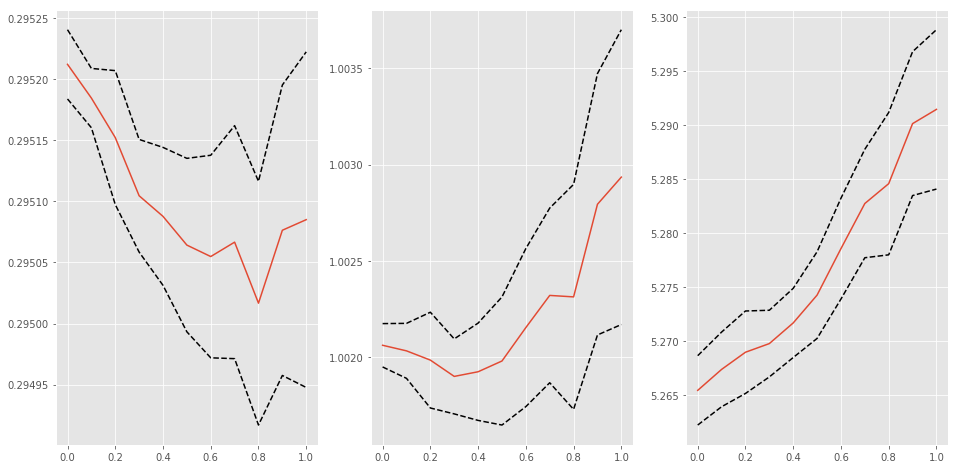

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,8])


ax1.plot(data['lin_size_qe'], gini_averages)
ax1.plot(data['lin_size_qe'], gini_conf_interval_uppers, 'k--')
ax1.plot(data['lin_size_qe'], gini_conf_intervals_lowers, 'k--')

ax2.plot(data['lin_size_qe'], palma_averages)
ax2.plot(data['lin_size_qe'], palma_conf_interval_uppers, 'k--')
ax2.plot(data['lin_size_qe'], palma_conf_intervals_lowers, 'k--')

ax3.plot(data['lin_size_qe'], twtw_averages)
ax3.plot(data['lin_size_qe'], twtw_conf_interval_uppers, 'k--')
ax3.plot(data['lin_size_qe'], twtw_conf_intervals_lowers, 'k--')

fig.savefig('qe_size_effect_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)